# Module 2 Summative Lab

## Introduction

For today's section, we're going to work on a single big lab to apply everything we've learned in Module 2!

## About This Lab

A quick note before getting started--this lab isn't like other labs you seen so far. This lab is meant to take ~8 hours to complete, so it's much longer and more challenging that the average labs you've seen so far. If you feel like this lab is challenging or that you might be struggling a bit, don't fret--that's by design! With everything we've learned about Web Scraping, APIs, and Databases, the best way to test our knowledge of it is to build something substantial! 

## The Project

In this lab, we're going to make use of everything we've learned about APIs, databases, and Object-Oriented Programming to **_Extract, Transform, and Load_** (or **_ETL_**, for short) some data from a SQL database into a MongoDB Database. 

You'll find a database containing information about soccer teams and the matches they've played in the file `database.sqlite`. For this project, our goal is to get the data we think is important from this SQL database, do some calculations and data transformation, and then store everything in a MongoDB database. 

Let's get into the specifics of this project.

### The Goal

Start by examining the data dictionary for the SQL database we'll be working with, which comes from this [kaggle page](https://www.kaggle.com/laudanum/footballdelphi).  Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database. 

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

* The name of the team
* The total number of goals scored by the team during the 2011 season
* The total number of wins the team earned during the 2011 season
* A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
* The team's win percentage on days where it was raining during games in the 2011 season. 

#### Getting the Weather Data

Note that for this last calculation, you'll need to figure out if it was raining or not during the game. The database itself does not contain this information, but it does contain the date on which the game was played. For this, you'll need to use the [DarkSky API](https://darksky.net/dev) to get the historical weather data for that day. Note that each game is played in a different location, and this information is not contained in our SQL database. However, the teams in this database are largely german, so go ahead and just use the weather in Berlin, Germany as a proxy for this information. If it was raining in Berlin on the day the game was played, count that as rain game--**_you do not need to try and figure out the actual weather at each game's location, because we don't have that information!_**

#### NOTE: The DarkSky API is limited to 1000 free API calls a day, so be sure to test your model on very small samples. Otherwise, you'll hit the rate limit!

## Project Architecture

Unlike previous labs, this lab is more open-ended, and will require you to make design decisions and plan out your strategy for building a system with this many working parts. However, **_using Object-Oriented Programming is a requirement for this project--you must create at least 2 separate, well structured classes in your solution!_** Although it may seem easier to "just start coding", this is a classic beginner's mistake. Instead, think about separating out the different functionalities you'll need to reach your goal, and then build classes to handle each. For instance, at minimum, you'll need to:

* Query the SQL database
* Calculate summary statistics
* Get the weather data from the DarkSky API
* Load the data into MongoDB

We **_strongly recommend_** you consider creating separate classes for handling at least some of these of these tasks.  Be sure to plan the inputs, outputs, and methods for each class before you begin coding! 

**_NOTE:_** We have provided some empty classes below. You are welcome to delete them and use a different architecture for this project if you so choose.  You do not have to use each of them, they are just there to give you an idea of what you could sorts of classes you may want to consider using.

### Rapid Prototyping and Refactoring

It's totally okay to try to get a task working without using OOP. For instance, when experimenting with the DarkSky API for getting historical weather data, it makes sense to just write the code in the cells and rapidly iterate until you get it all working. However, once you get it working, you're not done--you should then **_Refactor_** your code into functions or classes to make your code more modular, reusable, understandable, and maintainable! 

In short--do what you need to do to get each separate piece of functionality working, and then refactor it into a class after you've figured it out!

### Some Final Advice

You haven't built anything this big or complex thus far, so you may not yet fully realize how much trial and error goes into it. If your code keeps breaking, resist the urge to get frustrated, and just keep working. Software development is an iterative process!  No one writes perfect code that works the first time for something this involved. You're going to run into _a lot_ of small errors in this project, right up until the point where it just works, and then you're done! However, you can reduce these errors by planning out your code, and thinking about how all of the pieces fit together before you begin coding. Once you have some basic understanding of how it all will work, then you'll know what you need to build, and then all that is left is to build it!

In short:

* Plan ahead--you'll thank yourself later!
* Errors and broken code aren't bad, they're normal. 
* Keep working, and stay confident--you can do this!

Good luck--we look forward to seeing your completed project!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pymongo
import requests
import json

conn = sqlite3.connect('database.sqlite')
c = conn.cursor()

## Import data from SQL database, and mung into a pandas dataframe

In [2]:
#Extract match data from SQL, filtering for the 2011 season
#and German leagues. Save these to a dataframe 'df'.

c.execute("""select *
             from Matches
             where Season = '2011'
             and (Div = 'D1' or Div = 'D2')
             """)
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

In [3]:
#We define a pair of functions that translates the FTR column into
#Win, Draw, or Loss, depending on whether we are looking at the match
#from the perspective of home or away team

def dfHomeResult(match):
    if match == 'H':
        return 'Win'
    elif match == 'D':
        return 'Draw'
    elif match == 'A':
        return 'Loss'
    
def dfAwayResult(match):
    if match == 'A':
        return 'Win'
    elif match == 'D':
        return 'Draw'
    elif match == 'H':
        return 'Loss'

In [4]:
#We create two versions of df. The first will consider the home team,
#and see how many goals they scored, how many they conceded, and if they won or lost

dfHome = df.drop('AwayTeam', axis = 1)
dfHome['Result'] = dfHome['FTR'].map(lambda x: dfHomeResult(x))
dfHome = dfHome.drop('FTR', axis = 1)
dfHome.rename(columns={'HomeTeam':'Team', 'FTHG':'GoalsFor', 'FTAG':'GoalsAgainst'}, inplace = True)

#The second copy considers the away team, again seeing how many goals they scored,
#how many they conceded, and if they won or lost

dfAway = df.drop('HomeTeam', axis = 1)
dfAway['Result'] = dfAway['FTR'].map(lambda x: dfAwayResult(x))
dfAway = dfAway.drop('FTR', axis = 1)
dfAway.rename(columns={'AwayTeam':'Team', 'FTAG':'GoalsFor', 'FTHG':'GoalsAgainst'}, inplace = True)

#We then concatonate the two dataframes. This gives us a view of each match, from each team's
#perspective. This will be easier to query later on.

matches = pd.concat([dfHome,dfAway], sort = True).reset_index()
matches.drop('index', axis = 1, inplace = True)
matches

,Date,Div,GoalsAgainst,GoalsFor,Match_ID,Result,Season,Team
0,2012-03-31,D1,1,0,1092,Loss,2011,Nurnberg
1,2011-12-11,D1,2,1,1093,Loss,2011,Stuttgart
2,2011-08-13,D1,1,0,1094,Loss,2011,Wolfsburg
3,2011-11-27,D1,2,3,1095,Win,2011,Mainz
4,2012-02-18,D1,0,0,1096,Draw,2011,Freiburg
5,2012-01-20,D1,1,3,1097,Win,2011,M'gladbach
6,2012-02-04,D1,1,1,1098,Draw,2011,Hamburg
7,2012-04-21,D1,2,1,1099,Loss,2011,Werder Bremen
8,2011-09-18,D1,2,0,1100,Loss,2011,Schalke 04
9,2011-10-23,D1,1,2,1101,Win,2011,Hannover


## Create a class for dates, allowing us to check the weather on specific dates

In [5]:
class Date():
    def __init__(self, date):
        self.date = date
        
    def weather_report(self):
        #The key generated by DarkSky API
        key = 'd25950df48d930734bd1d4cdf2998061'
        
        #Latitude and longitude for Berlin
        lat = '52.31'
        long = '13.232'
        
        #Take the date in question, and assume 3pm kick off
        time = f'{self.date}T15:00:00'
        
        #Create URL using the above for API interface
        url = f'https://api.darksky.net/forecast/{key}/{lat},{long},{time}'
        r = requests.get(url)
        
        #Test for rain...
        if r.json()['currently']['icon'] == 'rain':
            return('Rain')
        else:
            return('No Rain')
        
    def games_played(self):
        return list(matches.loc[matches['Date'] == self.date]['Match_ID'].unique())

In [6]:
#Use the Date class defined above to create a list of 'match day' objects
match_days = [Date(i) for i in list(matches['Date'].unique())]

#Create a dictionary for each of these objects, which shows the date, and whether or not it was raining
rain_check_dict = {i.date: i.weather_report() for i in match_days}

In [7]:
#Function to return the rain or no rain condition from the dictionary above
def rain_check(date):
    return rain_check_dict[date]

#Create a column in the matches dataframe to see whether or not the match was played in rain
matches['Rain'] = matches['Date'].map(lambda x: rain_check(x))

In [8]:
matches

,Date,Div,GoalsAgainst,GoalsFor,Match_ID,Result,Season,Team,Rain
0,2012-03-31,D1,1,0,1092,Loss,2011,Nurnberg,No Rain
1,2011-12-11,D1,2,1,1093,Loss,2011,Stuttgart,No Rain
2,2011-08-13,D1,1,0,1094,Loss,2011,Wolfsburg,No Rain
3,2011-11-27,D1,2,3,1095,Win,2011,Mainz,No Rain
4,2012-02-18,D1,0,0,1096,Draw,2011,Freiburg,No Rain
5,2012-01-20,D1,1,3,1097,Win,2011,M'gladbach,No Rain
6,2012-02-04,D1,1,1,1098,Draw,2011,Hamburg,No Rain
7,2012-04-21,D1,2,1,1099,Loss,2011,Werder Bremen,No Rain
8,2011-09-18,D1,2,0,1100,Loss,2011,Schalke 04,No Rain
9,2011-10-23,D1,1,2,1101,Win,2011,Hannover,Rain


## Create a class for teams, allowing us to get the summary statistics

In [9]:
class Team():
    def __init__(self, name):
        self.name = name
    
    
    #Return total goals scored by team
    def goals_scored(self):
        return int(matches.loc[matches['Team'] == self.name]['GoalsFor'].sum())
    
    
    #Work out total number of games played in given weather conditions
    def matches_played(self, weather = None):
        if weather == None:
            return len(matches.loc[matches['Team'] == self.name])
        else:
            return len(matches.loc[(matches['Team'] == self.name)
                                   & (matches['Rain'] == weather)])
    
    
    #Work out total number of games won in given weather conditions
    def matches_won(self, weather = None):
        if weather == None:
            return len(matches.loc[(matches['Team'] == self.name)
                                   & (matches['Result'] == 'Win')])
        else:
            return len(matches.loc[(matches['Team'] == self.name)
                                   & (matches['Result'] == 'Win')
                                   & (matches['Rain'] == weather)])

        
    #Return ratio of matches won in rain, formatted as a percentage to 1d.p.
    def rain_win_ratio(self):
        if self.matches_played(weather = 'Rain') == 0:
            return 'No games played in rain'
        else:
            ratio = self.matches_won(weather = 'Rain') / self.matches_played(weather = 'Rain')
            return f'{round(100*ratio,1)}%'
    
    
    #Return a bar chart of results split by wins, draws, and losses
    def result_hist(self):
        results = matches.loc[matches['Team'] == self.name].groupby('Result').count()['Date']
        outcomes = ['Win', 'Draw', 'Loss']
        result_counts = [results[i] for i in outcomes]
        
        fig = plt.figure(figsize=(8, 6))
        plt.bar(outcomes, result_counts);
        plt.title(label = f'{self.name} Results in 2011/2012 Season');
        plt.ylabel('Games');
        
        return fig

/Users/Callum/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


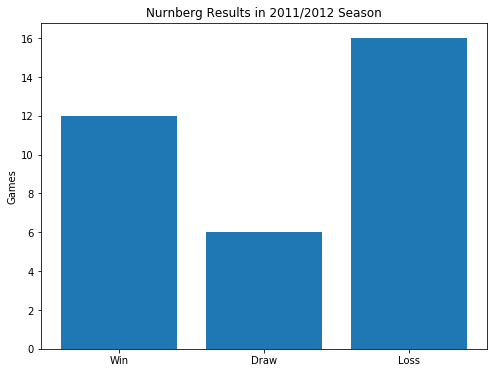

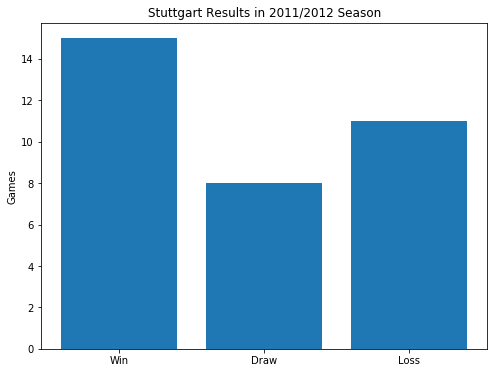

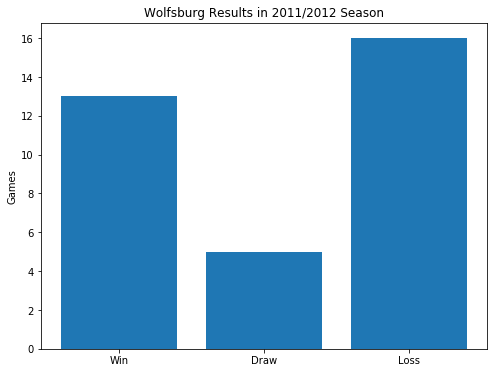

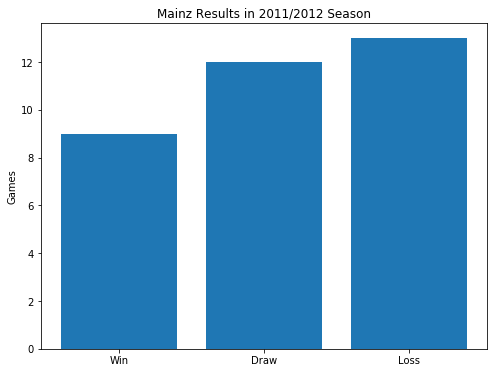

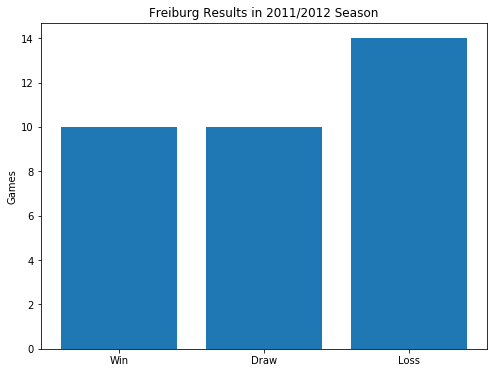

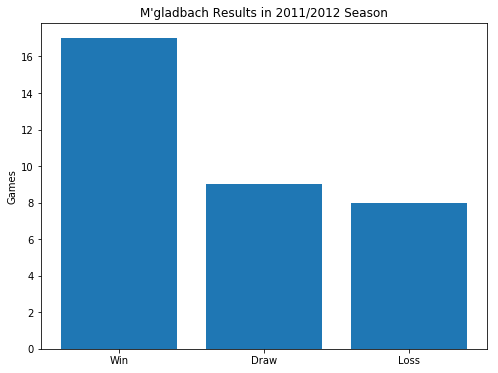

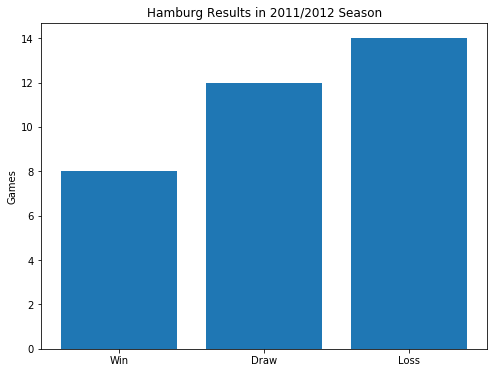

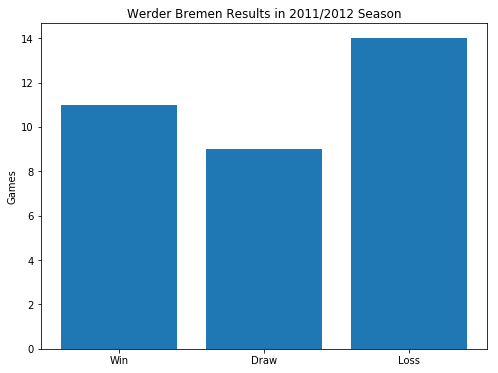

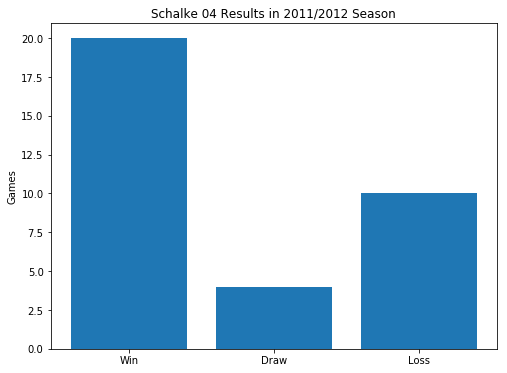

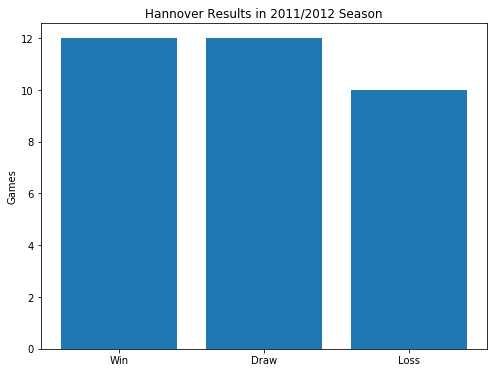

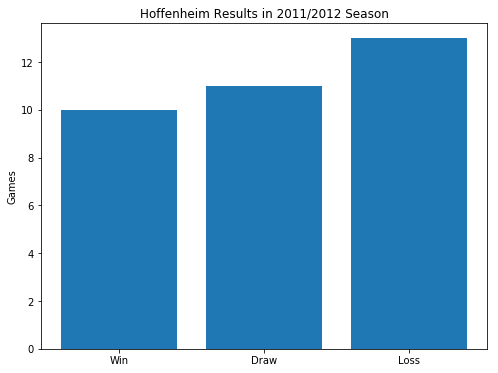

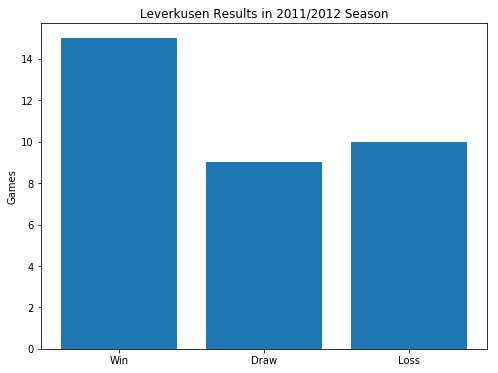

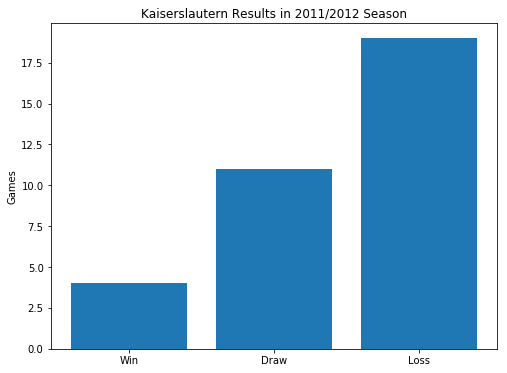

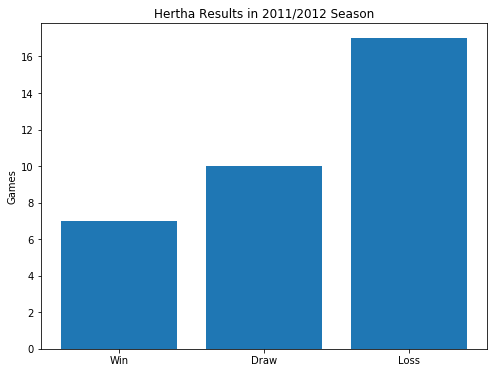

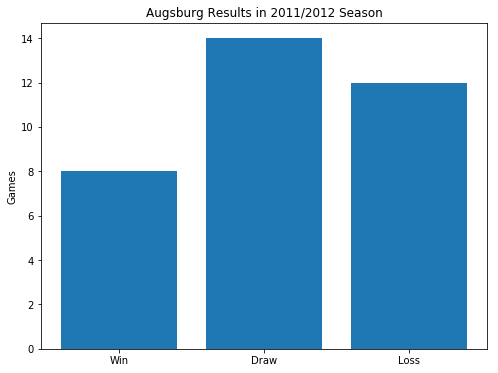

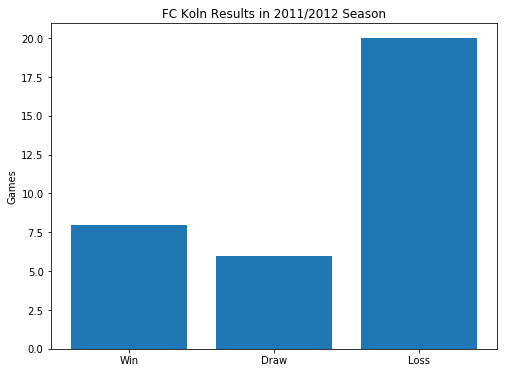

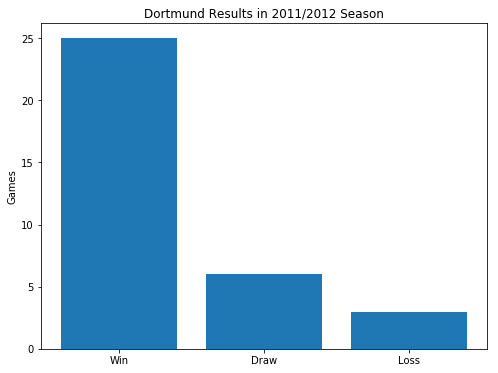

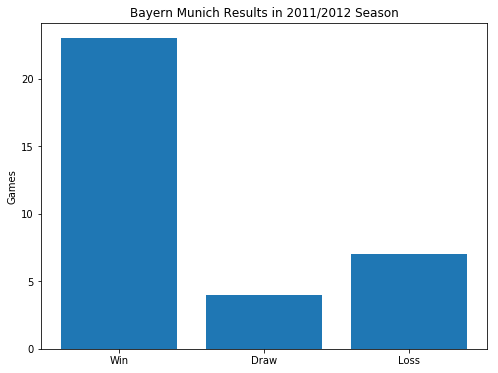

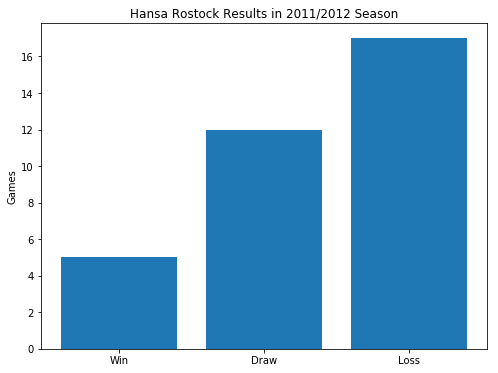

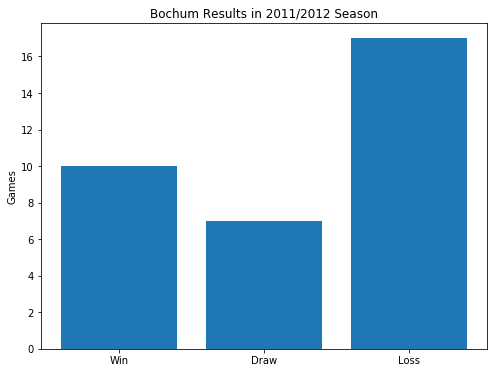

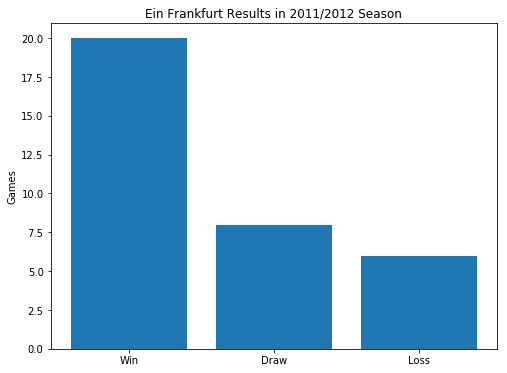

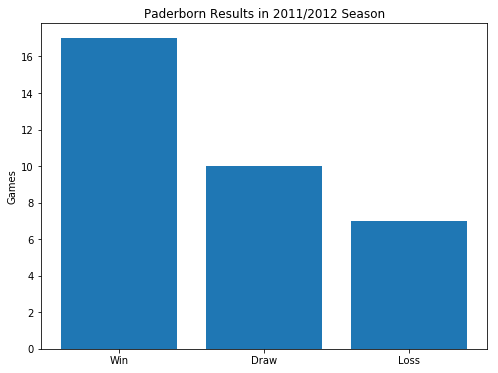

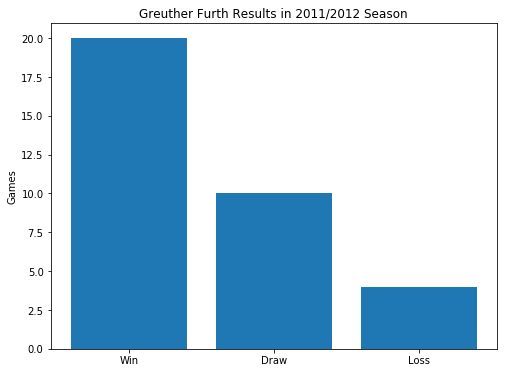

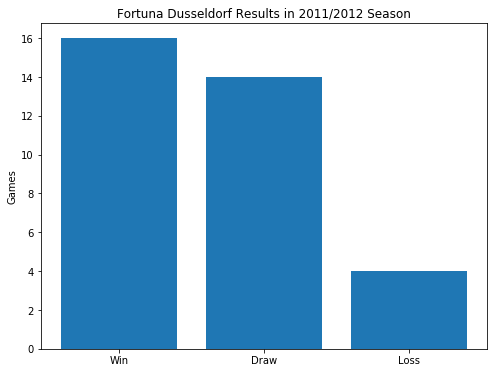

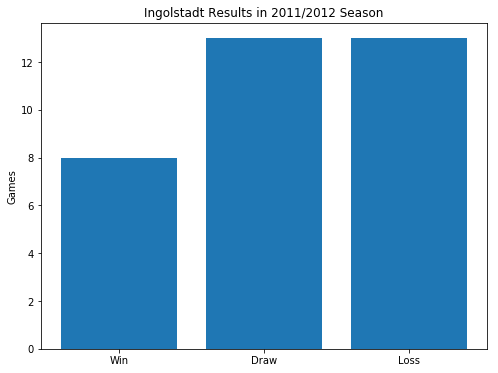

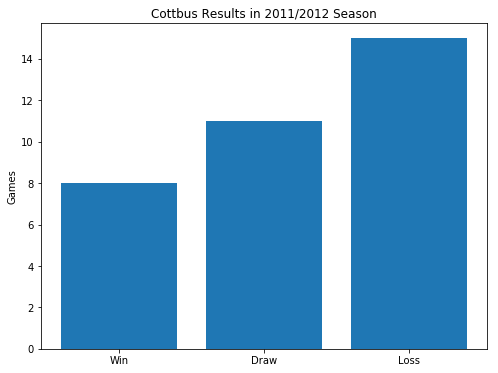

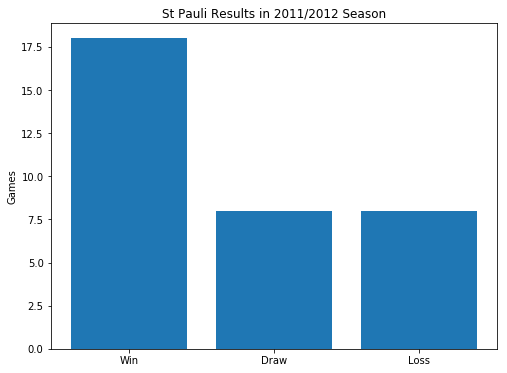

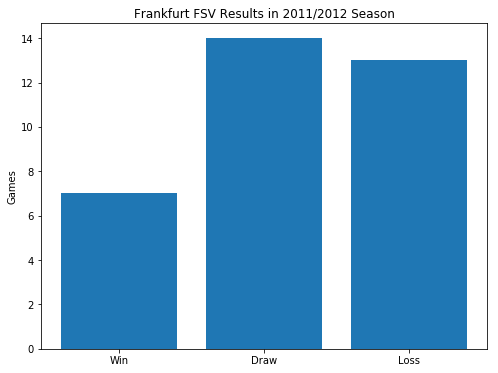

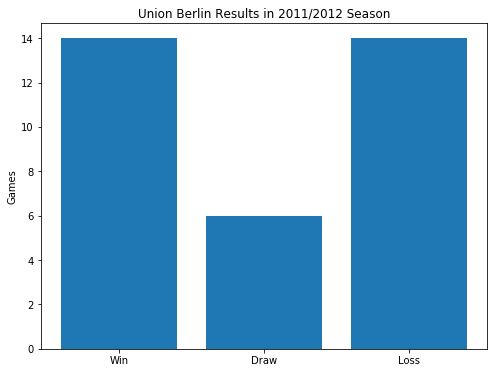

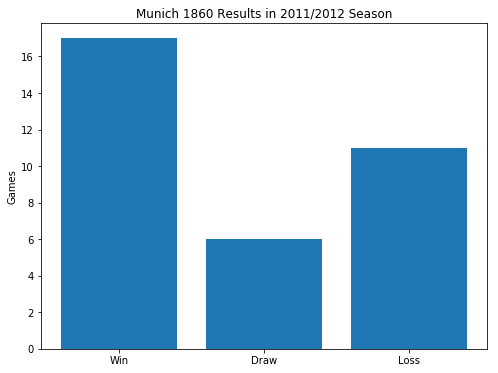

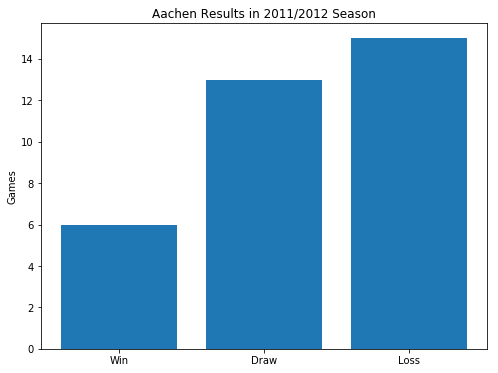

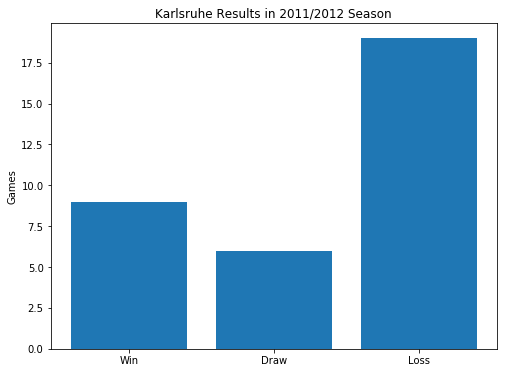

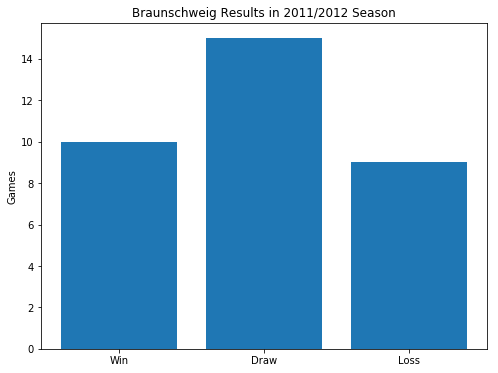

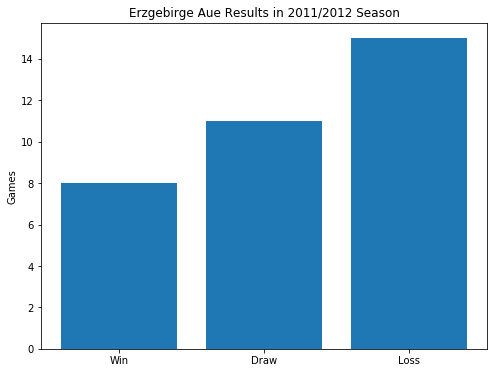

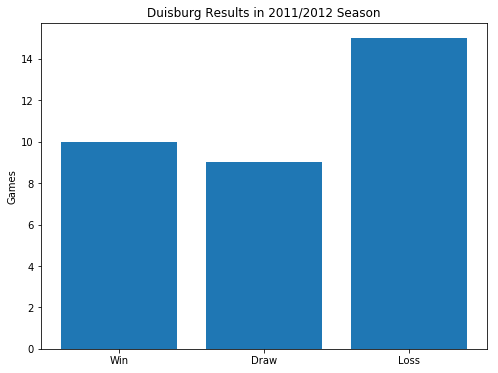

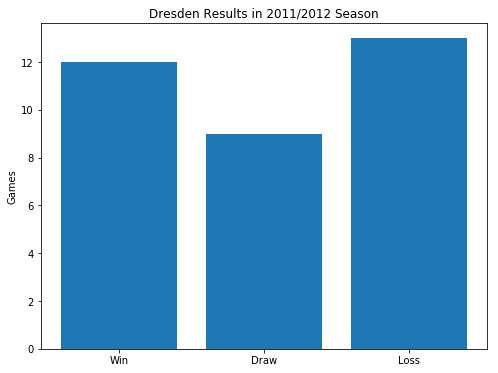

In [10]:
#Use the Team class defined above to create a list of 'team' objects
teams = [Team(i) for i in list(matches['Team'].unique())]

#Create a dictionary for these objects, which shows the team, and its summary stats
teams_dicts = [{'Team': i.name,
                'Stats': {'Goals scored': i.goals_scored(),
                          'Wins': i.matches_won(),
                          'Result Histogram': i.result_hist(),
                          'Rain Win Ratio': i.rain_win_ratio()}}
               for i in teams]

In [11]:
teams_dicts

[{'Team': 'Nurnberg',
  'Stats': {'Goals scored': 38,
   'Wins': 12,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': 'No games played in rain'}},
 {'Team': 'Stuttgart',
  'Stats': {'Goals scored': 63,
   'Wins': 15,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': '0.0%'}},
 {'Team': 'Wolfsburg',
  'Stats': {'Goals scored': 47,
   'Wins': 13,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': '0.0%'}},
 {'Team': 'Mainz',
  'Stats': {'Goals scored': 47,
   'Wins': 9,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': '0.0%'}},
 {'Team': 'Freiburg',
  'Stats': {'Goals scored': 45,
   'Wins': 10,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': '0.0%'}},
 {'Team': "M'gladbach",
  'Stats': {'Goals scored': 49,
   'Wins': 17,
   'Result Histogram': <Figure size 576x432 with 1 Axes>,
   'Rain Win Ratio': '50.0%'}},
 {'Team': 'Hamburg',
  'Stats': 

## Upload all we've found to MongoDB

In [12]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['example_database']
teamcollection = mydb['team_collection']

In [13]:
# results = teamcollection.insert_many(teams_dicts)

# Summary

In this lab, we dug deep and used everything we've learned so far about python programming, databases, HTTP requests and API calls to ETL data from a SQL database into a MongoDB instance!